General review:

https://genomebiology.biomedcentral.com/articles/10.1186/gb-2003-4-4-210

(doi:10.1186/gb-2003-4-4-210)

## Subtask 0: Download the data

hint:

http://science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx

In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import math
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr,bartlett, levene,normaltest,mannwhitneyu
from scipy.stats.mstats import zscore
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.graphics.gofplots import qqplot_2samples,qqplot
import statsmodels.api as sm
import urllib2
import random as rd

In [13]:
% matplotlib inline

In [14]:
!mkdir -p Day4_InOutput

In [4]:
#!wget Day4_InOutput/aad0189_DataFileS5.xlsx, "http://science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx"

## Task 1: Data wrangling

hint:

http://www.arrayanalysis.org/main.html

### Subtask 1.1: Read in aad0189_DataFileS5.xlsx with pandas

In [5]:
data = pd.read_excel("Day4_InOutput/aad0189_DataFileS5.xlsx",header=2)
data.head()

,Original_Order,MATCH_ORDER,Gene,Probeset,Gene.1,Protein,Unnamed: 6,Range CD,Range HFD,Range_All,...,BXD89_Liver_HFD,BXD90_Liver_HFD,BXD95_Liver_HFD,BXD96_Liver_HFD,BXD97_Liver_HFD,BXD98_Liver_HFD,BXD99_Liver_HFD,BXD100_Liver_HFD,BXD101_Liver_HFD,BXD103_Liver_HFD
0,12643,NaN,Igh,10403036,Igh,0,NaN,1.495886,1.720705,1.720705,...,4.959,5.483,5.347,5.087,5.125,5.160,5.020,5.170,4.775,4.982
1,12646,NaN,Igh,10403043,Igh,0,NaN,2.938337,1.988940,3.595021,...,7.415,7.252,7.547,7.358,7.424,7.447,7.567,7.732,7.365,7.369
2,12653,NaN,Igh,10403063,Igh,0,NaN,3.719220,1.859610,4.260433,...,6.665,6.948,6.999,6.974,6.886,6.876,7.027,7.093,6.748,6.771
3,8759,1458.0,Hcfc2,10365242,Hcfc2,A0AUN4,NaN,1.479388,1.465101,1.536875,...,9.177,9.021,8.803,8.928,8.914,8.838,9.056,8.924,8.945,8.865
4,18740,8191.0,Ccdc112,10458794,Ccdc112,A0AUP1,NaN,1.834008,1.943962,1.997229,...,6.623,6.371,6.187,6.310,6.448,6.531,6.167,6.401,6.470,6.565


### Subtask 1.2: Average over different probesets for a gene and generate a dataframe containing each gene symbol (once)  as rows and the corresponding averaged expression values for each strain + condition as columns

In [6]:
data= data.groupby(data["Gene"],as_index=True,sort=False).mean()

### Subtask 1.3: Quantile normalization: carry out a quantile normalization of the data (or not)

#### Subsubtask 1.3.1: Implement a ratio intensity plot (using matplotlib)

In [7]:
def ratio_intensity_plot(x_,y_):
    x = np.array(x_)
    y = np.array(y_)
    R = np.log10(x/y)
    I = (np.log10(x)+np.log10(y))/2
      
    #prepare plot
    plt.figure(figsize=(10,6),dpi=100)
    plt.ylabel("Ratio")
    plt.xlabel("Intensity")
    plt.title("Ratio-Intensity Plot")
    plt.axhline(0,0,color="red")
    plt.scatter(I,R,color="green")
    ax = plt.gca()
    ax.set_axis_bgcolor("white")
    plt.show()

#### Subsubtask 1.3.2: Apply your ratio intensity plot to several pairs of chips (columns of your above dataframe)

In [8]:
ratio_intensity_plot(data["C57BL/6J_Liver_CD"],data["DBA/2J_Liver_CD"])

In [9]:
ratio_intensity_plot(data["BXD71_Liver_CD"],data["BXD73_Liver_CD"])

In [10]:
ratio_intensity_plot(data["BXD45_Liver_HFD"],data["BXD45_Liver_CD"])

In [11]:
ratio_intensity_plot(data["BXD101_Liver_HFD"],data["BXD103_Liver_HFD"])

#### Subsubtask 1.3.3: Implement a rle plot (rle = relative log expression)

In [12]:
def rle_plot(data):
    avg = data.T/data.T.median()
    plt.figure(figsize=(16,12), dpi=80)
    plt.title("Relative log expression",fontsize=16)
    plt.xlabel("Sample",fontsize=10)
    plt.ylabel("Relative log expression",fontsize=12)
    plt.xticks(range(len(data)), data.index,
           rotation="vertical", fontsize=10)
    ax = plt.gca()
    ax.set_axis_bgcolor("white")
    sns.boxplot(data=np.log10(avg.T));

#### Subsubtask 1.3.4: Apply your RLE plot to the data

The column "Unnammend: 51" needs to be dropped since all values are NaN. 

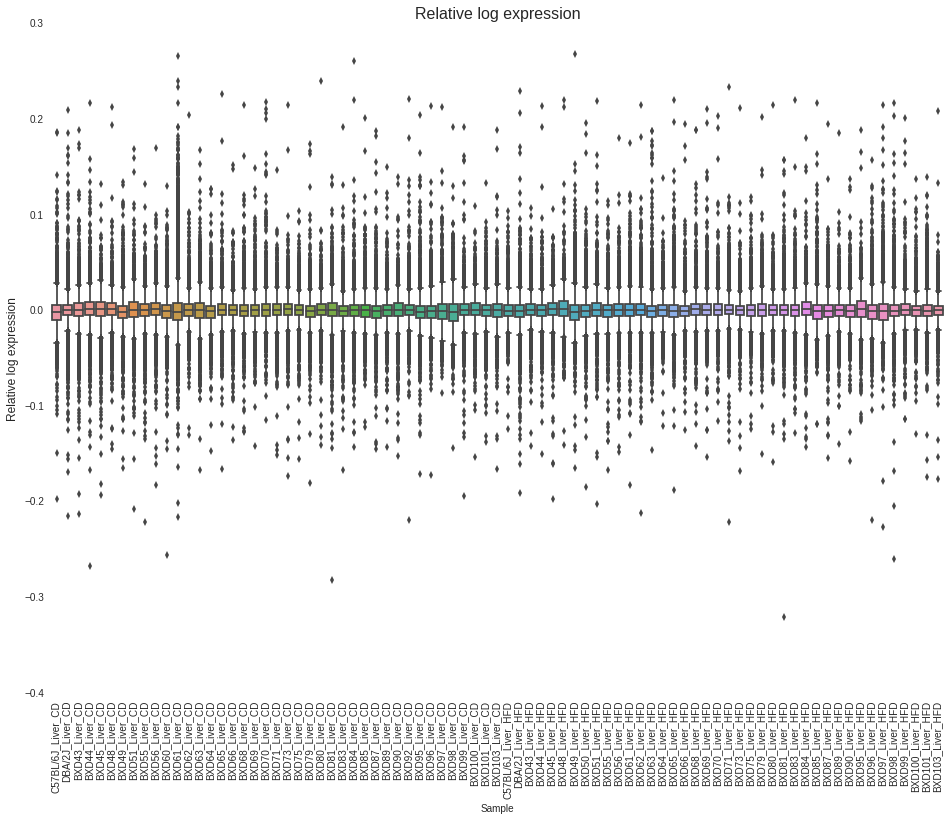

In [13]:
rle_plot(data.drop("Unnamed: 51",axis=1).ix[:,7:])

#### Subsubtask 1.3.5: If you consider it necessary, perform a quantile normalization of the data 

The ratio-intensity plots and the RLE plot show that the data are allready normalized. Hence, we continue without perform a quantile normalization. The small oscilliations of the q25 and q75 quantiles in the RLE plt can be neglected. 

## Task 2: Which statistical test to chose?

We want to infer differentially expressed genes between the CD and the HFD condition. Therefore we (mis)(?)treat (!) the (already) normalized expression values of all the strains for a given condition as independent observations of the same sample. But first we need to figure out which statistical test for differential expression seems appropriate (concerning distribution and variance assumptions) and then apply it. Limit yourself to the Student t-test, the Welch t-test or Wilcoxon's rank-sum test (also sometimes refered to as Whitney-Mann U-test).

Everything you may need, is most likely found here:

http://docs.scipy.org/doc/scipy-0.17.1/reference/stats.html 

http://statsmodels.sourceforge.net/stable/graphics.html

### Subtask 2.1: Do the CD and HFD samples have equal variance?

Josef-Francisco Del-Marre-Doyle, famous and visionary president of the International BXD Society (IBXDS), just gave a celebrated TED-talk in which he reviewed the fact that any statistic associated with the universe is almost surely normally distributed, and hence you canonically assume that the only thing left to check is whether the samples have equal variance, that is whether to apply Student's or Welch's t-test. Josef-Francisco's assessment usually is that "things are equal" and so you're quite confident that you'll be able to use Student's t-test. But since you're an excellent scientist (and, additionally, won't pass the course otherwise) you still do the following certainly unnecessary work:

#### Subsubtask 2.1.1: Choose a random row of your latest dataframe using the random module of Python

In [15]:
# extract random row
random_sample = rd.randint(7,len(data))
print "Random Row: ", random_sample
hfd_temp = data.ix[random_sample][data.ix[random_sample].index.str.contains("_HFD") ]
cd_temp = data.ix[random_sample][data.ix[random_sample].index.str.contains("_CD")]
#remove column with sample BXD92_Liver_CD hence there is no BXD92_Liver_HFD sample
cd_temp = cd_temp[~cd_temp.index.str.contains("92")]

Random Row:  17774


#### Subsubtask 2.1.2: Make a Q-Q plot comparing the two samples for the just chosen gene and answer the question: Does this tell you anything?

In [16]:
def qqplot_random(x,y):
    """
        Plots a 2-sample qq plot for two data series: X = HFD, Y = CD
    """
    # prepare plot
    plt.figure(figsize=(10,6), dpi=100)
    plt.title("QQ-Plot HFD vs. CD samples",fontsize=16)
    plt.ylabel("Quantiles of HFD Sample")
    plt.xlabel("Quantiles of CD Sample")
    plt.grid(True, color="lightgrey")
    ax = plt.gca()
    ax.set_axis_bgcolor("white")
    qqplot_2samples(x.values,y.values,ax=ax,line="45")
    plt.show()

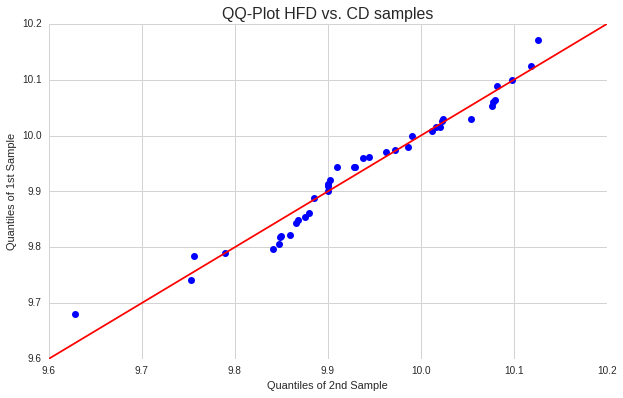

In [17]:
qqplot_random(hfd_temp,cd_temp)

#### Subsubtask 2.1.3: Apply an appropriate statistical test in order to figure out whether the samples have equal variance (there may be more than one sensible solution)

In [18]:
print bartlett(hfd_temp,cd_temp)
print levene(hfd_temp,cd_temp)

BartlettResult(statistic=0.015528202599995572, pvalue=0.90083056245918947)
LeveneResult(statistic=0.06354185026875378, pvalue=0.8016460516910735)


Since the Levene test for equal variance and also the more sensible Bartlett test does not reject the null hypothesis for $\alpha=0.05$ for all possible samples(both samples have equal variance), we cannot assume equal variance for the chosen samples.

#### Subsubtask 2.1.4: To asses the global situation, plot a histogram of p-values for all the genes (using the same test you chose in 2.1.3)

In [19]:
hfd_all = data[data.columns[data.columns.str.contains("_HFD")]]
cd_all = data[data.columns[data.columns.str.contains("_CD")]]
cd_all=cd_all[cd_all.columns[~cd_all.columns.str.contains("92")]]

In [18]:
a = [bartlett(np.array(x[1:]).T,np.array(y[1:]).T).pvalue for x,y in zip(cd_all.iterrows(),hfd_all.iterrows())]

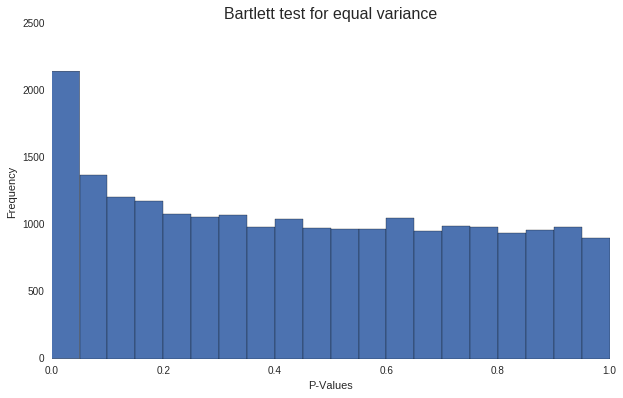

In [19]:
plt.figure(figsize=(10,6), dpi=100)
plt.title("Bartlett test for equal variance",fontsize=16)
plt.ylabel("Frequency")
plt.xlabel("P-Values")
#plt.grid(True, color="lightgrey")
ax = plt.gca()
ax.set_axis_bgcolor("white")
plt.hist(a,bins=20)
plt.show()

### Subtask 2.2 Are the CD and HFD samples normally distributed?

Utterly shocked and overwhelmed by ambiguous emotions you begin to doubt the wisdom of Josef-Francisco and start a top-secret and highly dangerous investigation whether the samples are at least normally distributed. Be careful whom you'll tell about that you're working on this...

#### Subsubtask 2.2.1: Using the same gene randomly chosen above, make a Box plot for the corresponding CD and HFD sample and give an interpretation

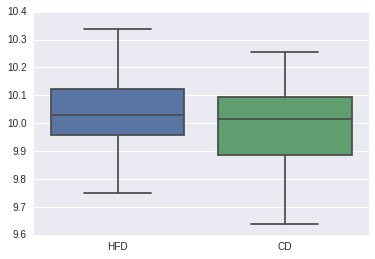

In [21]:
sns.boxplot(pd.DataFrame([np.array(hfd_all.ix[random_sample]),np.array(cd_all.ix[random_sample])],index=["HFD","CD"]).T);

The boxplot shows that the quantiles of the values differ between HFD and CD. This supports the results of the Bartlett tets. Consequently, any statistical test used in further analysis should not assume equal variance for HFD and CD. 

#### Subsubtask 2.2.2: Just like in 2.2.1 make Q-Q plots for each sample (compare each to the theoretical normal distribution) and try an interpretation.

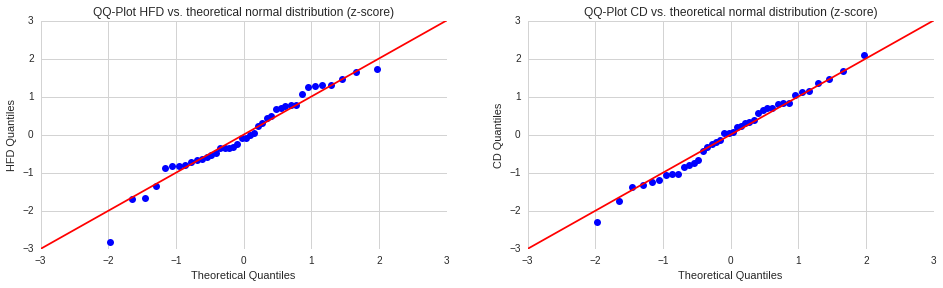

In [20]:
plt.figure(figsize=(16,9), dpi=100)
plt.subplot(221)
plt.title("QQ-Plot HFD vs. theoretical normal distribution (z-score)",fontsize=12)
plt.grid(True, color="lightgrey")
ax = plt.gca()
ax.set_axis_bgcolor("white")
qqplot(zscore(cd_all.ix[random_sample]),line="45",ax=ax)
plt.ylabel("HFD Quantiles")
plt.subplot(222)
plt.title("QQ-Plot CD vs. theoretical normal distribution (z-score)",fontsize=12)
plt.grid(True, color="lightgrey")
ax = plt.gca()
ax.set_axis_bgcolor("white")
qqplot(zscore(hfd_all.ix[random_sample]),line="45",ax=ax)
plt.ylabel("CD Quantiles")
plt.show()

The QQ-Plots show that the quantiles of the randomly chosen sample is highly similar to the quantiles of the theoretical normal distribution. 

#### Subsubtask 2.2.3: Apply an appropriate statistical test in order to figure out whether the samples are normally distributed (there may be more than one sensible solution)

In [21]:
print normaltest(hfd_all.ix[random_sample])
print normaltest(cd_all.ix[random_sample])

NormaltestResult(statistic=0.68461914345568708, pvalue=0.71012833502255024)
NormaltestResult(statistic=1.2530006968402676, pvalue=0.53445895202805538)


In [24]:
hfd_pvals_norm = [normaltest(np.array(x[1:]).T).pvalue for x in hfd_all.iterrows()]
cd_pvals_norm = [normaltest(np.array(x[1:]).T).pvalue for x in cd_all.iterrows()]

#### Subsubtask 2.2.4: To asses the global situation, plot a histogram of p-values for all the genes (using the same test you chose in 2.2.3)

In [ ]:
plt.figure(figsize=(10,6), dpi=100)
#plt.subplot(221)
plt.title("Normal test for HFD samples",fontsize=16)
plt.ylabel("Frequency")
plt.xlabel("P-Values")
ax = plt.gca()
ax.set_axis_bgcolor("white")
plt.hist(hfd_pvals_norm)
#plt.subplot(222)
#plt.title("Normal test for CD samples",fontsize=16)
#plt.ylabel("Frequency")
#plt.xlabel("P-Values")
#ax = plt.gca()
#ax.set_axis_bgcolor("white")
#plt.hist(cd_pvals_norm)
plt.show()

#### Subsubtask 2.2.5: Write a 1-word essay about whether there is any instrinsic philosophical reason that any data follows a normal distribution

No

### Subtask 2.3 Choose a suitable statistical test to assess differential expression, apply it to every row, store the results in a suitable dataframe (you may want to order the genes with respect to their p-values) and finally extract a list of differentially expressed genes (5% significance). How many differentially expressed genes do you get?

In [310]:
pvals_mwu = pd.DataFrame(
    [mannwhitneyu(np.array(x[1:]).T,np.array(y[1:]).T).pvalue for x,y in zip(hfd_all.iterrows(),cd_all.iterrows())],
    index=hfd_all.index,columns=["pval_mwu"])

In [311]:
diff_exp_genes = pvals_mwu[pvals_mwu.pval_mwu < 0.05]
print "%s genes are tested to be differentially expressed using Mannwhitney-U Test."%(len(diff_exp_genes))

13424 genes are tested to be differentially expressed using Mannwhitney-U Test.


## Task 3: Multiple-testing correction

You receive an anonymous letter revealing to you that you should do multiple-testing correction, otherwise something awfully bad will happen, or not. Puzzled and shaking you embark on this endeavour.

Fredholm, your lab's vodoo priest, is convinced that applying anything else than Bonferroni correction brings death and destruction to the people on the moon. Opportunistically neglecting any potential societal consequences of your actions (technology is neutral after all and who cares about the moon anyway!) you're obsessed to try as many multiple testing procedures as possible.

Everything you may need, is most likely found here:

http://statsmodels.sourceforge.net/stable/stats.html#multiple-tests-and-multiple-comparison-procedures

### Subtask 3.1: For your official report you have to pretend to care about Bonferroni's correction (otherwise it will never pass through Fredholm's office): manually code it (do not use the statsmodels implementation for example) and store the results in a suitable dataframe. How many differentially expressed gene do you get?

The bonferroni correction corrects for the number of the conducted tests n as follows: $p = \frac{\alpha}{n}$. 

In [312]:
diff_exp_genes_corrected = pvals_mwu[pvals_mwu.pval_mwu< (0.05/len(pvals_mwu))]
print "After the very strict bonferroni correction, %s genes remain."%(len(diff_exp_genes_corrected))

After the very strict bonferroni correction, 3096 genes remain.


### Subtask 3.2: Apply all multiple testing procedures you can get your hands on (except Bonferroni; now you should use statsmodels) to your uncorrected p-values and store the results in one (!) dataframe. 

In [396]:
tests = ["sidak", "holm-sidak", "holm", "simes-hochberg", 
        "hommel", "fdr_bh", "fdr_by", "fdr_tsbh","fdr_tsbky"]
    
def test(method):  
    return multipletests(pvals_mwu.pval_mwu, alpha=0.05, method=m, is_sorted=False, returnsorted=False)[1]

multiple_correction = pd.DataFrame.from_records(
        pd.Series(
        [multipletests(pvals_mwu.pval_mwu, alpha=0.05, method=m, is_sorted=False, returnsorted=False)[1]
        for m in tests])
        ).T
multiple_correction.columns=tests
multiple_correction.index=pvals_mwu.index

### Subtask 3.3: External visual comparison of the different methods
1 Write the DE dataframe to a csv file.
2 add a row with either 'numeric' or 'factor' as the first row to describe the data schema and save the file
3 use [paco](http://parallelcoordinates.de/paco) to visualize your data in parallel coordinates
4 which of the multiple testing methods is the most stringent? What's the relation between the others?

In [314]:
f = pd.DataFrame([["numeric"]*len(multiple_correction.columns)], columns=multiple_correction.columns)
multiple_correction_file = f.append(multiple_correction)
multiple_correction_file.to_csv("Day4_InOutput/correction_methods_comparison.csv", sep="\t",index=False)

In [316]:
# the following list is created using the command:

accepted_genes = [len(multiple_correction[multiple_correction[x] < 0.05]) for x in multiple_correction]
accepted_genes = [3096, 3106, 3181, 3164, 3164, 3312, 12183, 7908, 14340, 14144]

print "Number of accepted genes:"
for i in range(len(accepted_genes)-1):
    if i == 0:
        print "bonferroni : ", accepted_genes[i]
    else:
        print tests[i],": ", accepted_genes[i]

Number of accepted genes:
bonferroni :  3096
holm-sidak :  3106
holm :  3181
simes-hochberg :  3164
hommel :  3164
fdr_bh :  3312
fdr_by :  12183
fdr_tsbh :  7908
fdr_tsbky :  14340


This shows that bonferroni is the most stringet correction method for multiple testing. That is also supported  by the visual analysis of the data in paco. All corrected p.values correlate (no crossing lines in the parallel coordinates plot) and fdr_bh, fdr_tsbh and fdr_tsbky show the same results (horizontal lines in paco). 

### Subtask 3.4: Select a random method applied in 3.2 and extract the corresponding list of differentially expressed genes. Is this list contain more or less genes than the list from 2.3? Does it contain more or less genes than your Bonferroni list? ;)

As shown above, all other correction methods find more differentiallly expressed genes than Bonferroni. 

## Task 4: Vulcano plots

Marie de la Stratonovich, the devious intellectual opponent of your (former) beloved idol Josef-Francisco Del-Marre-Doyle just received the glorious Popel prize (the first marsian scientist ever to reveive that prize) for copy-pasting the content of the following papers:

1) arXiv:1103.3434 (https://arxiv.org/abs/1103.3434)

2) http://www.ncbi.nlm.nih.gov/pubmed/23602812 (doi:10.1016/j.compbiolchem.2013.02.003)

Overwhelmed by these achievments (and motivated by your ever declining esteem for Josef-Francisco) your're immensely excited about the joyous prospect of carrying out out the following tasks:

### Subtask 4.1: Add a log2 fold change column to the data frame from 3.2 and store it as a csv file.

In [397]:
log2fc = pd.DataFrame([cd_all.ix[i].mean() - hfd_all.ix[i].mean() for i in range(len(hfd_all))],index=cd_all.index,columns=["log2FC"])
multiple_correction_fc = multiple_correction.join(log2fc)

### Subtask 4.2:  Implement a Vulcano plot (from scratch using matplotlib)

In [415]:
def plot_vulcano(p,fc):
    plt.figure(figsize=(10,6), dpi=100)
    plt.title("Volcano Plot",fontsize=16)
    plt.ylabel("-log P")
    plt.xlabel("log2 FC")
    ax = plt.gca()
    ax.set_axis_bgcolor("white")

    log_p = np.array([-np.log10(x) for x in p])
    plt.scatter(-fc,log_p)
    #print log_fc

### Subtask 4.3: Apply your Volcano plot implementation to the uncorrected p-values, as well as the corrected p-values from 3.4 (you should have two plots in the end ;))

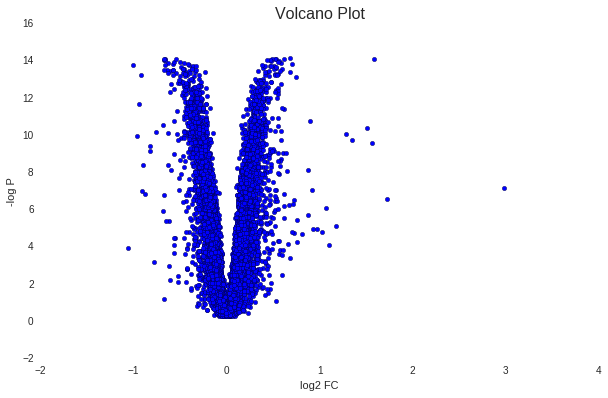

In [416]:
plot_vulcano(pvals_mwu.pval_mwu,multiple_correction_fc["log2FC"].values)

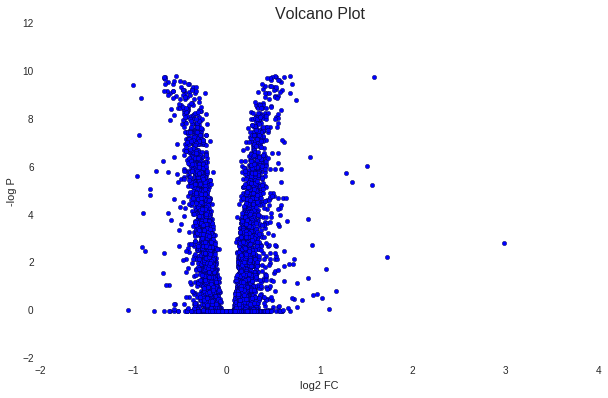

In [417]:
plot_vulcano(multiple_correction["sidak"],multiple_correction_fc["log2FC"].values)

## Task 5: RNA-seq

There are faint rumours that some supposedly revolutionary technology could also be used to study gene expression. Find out the name of that technology and outline the most striking difference of that technology compared to microarrays from a statistical modeling point of view.